In [28]:
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance", "statsmodels", "pandas", "numpy", "matplotlib"])
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [29]:
tickers = ['GOOGL', 'GOOG']
print(f"📡 DOWNLOADING DATA FOR: {tickers}...")
raw_data = yf.download(tickers, start="2022-01-01", end="2024-01-01")

/tmp/ipython-input-555384780.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2022-01-01", end="2024-01-01")
[*********************100%***********************]  2 of 2 completed

📡 DOWNLOADING DATA FOR: ['GOOGL', 'GOOG']...


In [30]:
if 'Adj Close' in raw_data:
    data = raw_data['Adj Close']
else:
    data = raw_data['Close']
data = data.dropna()

In [31]:
score, pvalue, _ = coint(data['GOOGL'], data['GOOG'])

print(f"STATISTICAL COINTEGRATION TEST")
print("\n")
print(f"Pair:          GOOGL vs GOOG")
print(f"P-Value:       {pvalue:.6f}")
print("\n")

if pvalue < 0.05:
    print("VERDICT: COINTEGRATED (P < 0.05)")
    print("   Since the pair is mathematically linked you can Trade.")
else:
    print("VERDICT: NOT COINTEGRATED. Do not trade.")

STATISTICAL COINTEGRATION TEST


Pair:          GOOGL vs GOOG
P-Value:       0.016332


VERDICT: COINTEGRATED (P < 0.05)
   Since the pair is mathematically linked you can Trade.


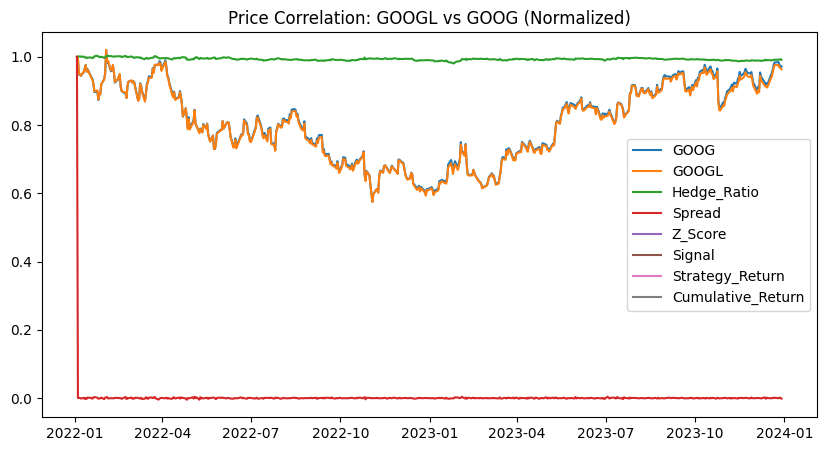

In [47]:
normalized_data = data / data.iloc[0]
plt.figure(figsize=(10, 5))
plt.plot(normalized_data, label=data.columns)
plt.title("Price Correlation: GOOGL vs GOOG (Normalized)")
plt.legend()
plt.show()

In [32]:
#Kalman filter

In [33]:
class KalmanFilterReg:
    def __init__(self, delta=1e-4, R=1e-3):
        self.n = 2
        self.state_mean = np.zeros(self.n)
        self.state_cov = np.ones((self.n, self.n))
        self.F = np.eye(self.n)
        self.Q = delta / (1 - delta) * np.eye(self.n)
        self.R = R

    def update(self, target, observation):
        H = np.array([observation, 1.0])

        pred_state_mean = self.state_mean
        pred_state_cov = self.state_cov + self.Q

        y_pred = H.dot(pred_state_mean)
        error = target - y_pred

        S = H.dot(pred_state_cov).dot(H.T) + self.R
        K = pred_state_cov.dot(H.T) / S

        new_state_mean = pred_state_mean + K * error
        new_state_cov = pred_state_cov - np.outer(K, H).dot(pred_state_cov)

        self.state_mean = new_state_mean
        self.state_cov = new_state_cov

        return new_state_mean[0], error

In [34]:
kf = KalmanFilterReg(delta=1e-4, R=0.001)
slopes = []
spreads = []

In [35]:
y_series = data['GOOGL'].values
x_series = data['GOOG'].values

In [36]:
for x, y in zip(x_series, y_series):
    slope, error = kf.update(y, x)
    slopes.append(slope)
    spreads.append(error)

In [37]:
data['Hedge_Ratio'] = slopes
data['Spread'] = spreads

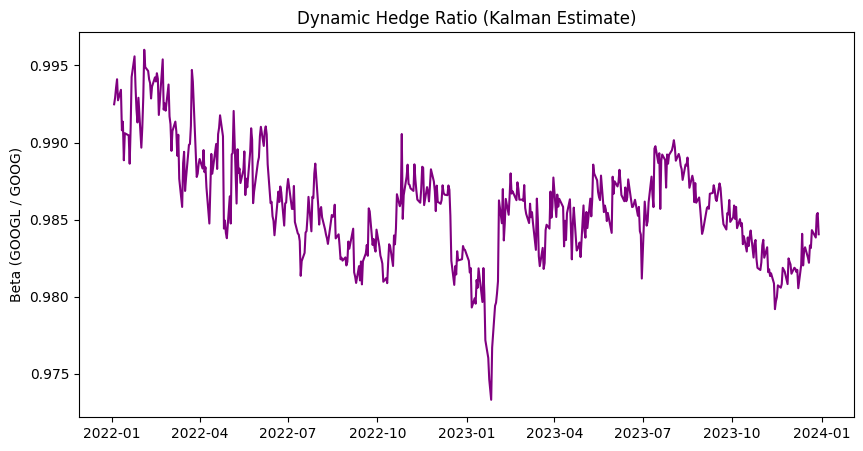

Purple line shows the model adapting in real-time.


In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.index, data['Hedge_Ratio'], color='purple')
ax.set_title("Dynamic Hedge Ratio (Kalman Estimate)")
ax.set_ylabel("Beta (GOOGL / GOOG)")
plt.show()
print("Purple line shows the model adapting in real-time.")

In [39]:
#generating alphas

In [40]:
window = 20
rolling_mean = data['Spread'].rolling(window=window).mean()
rolling_std = data['Spread'].rolling(window=window).std()
data['Z_Score'] = (data['Spread'] - rolling_mean) / rolling_std

In [41]:
data['Signal'] = 0
data.loc[data['Z_Score'] > 1.0, 'Signal'] = -1
data.loc[data['Z_Score'] < -1.0, 'Signal'] = 1
data['Signal'] = data['Signal'].fillna(0)

In [42]:
ret_y = data['GOOGL'].pct_change()
ret_x = data['GOOG'].pct_change()
pair_ret = ret_y - data['Hedge_Ratio'].shift(1) * ret_x

In [43]:
data['Strategy_Return'] = data['Signal'].shift(1) * pair_ret
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

In [44]:
sharpe = (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * np.sqrt(252)
total_ret = data['Cumulative_Return'].iloc[-1] - 1

In [45]:
print(f"PERFORMANCE REPORT")
print("\n")
print(f"Total Return:    {total_ret*100:.2f}%")
print(f"Sharpe Ratio:    {sharpe:.2f} (Target > 1.5)")


PERFORMANCE REPORT


Total Return:    8.83%
Sharpe Ratio:    3.15 (Target > 1.5)


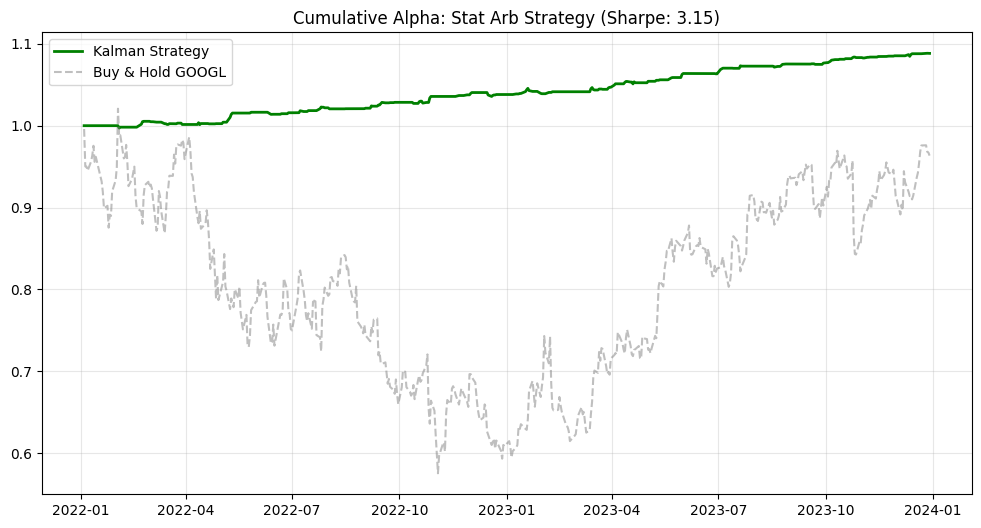

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Return'], color='green', linewidth=2, label='Kalman Strategy')
plt.plot((1+ret_y).cumprod(), color='gray', linestyle='--', alpha=0.5, label='Buy & Hold GOOGL')
plt.title(f"Cumulative Alpha: Stat Arb Strategy (Sharpe: {sharpe:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()